In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import dask.dataframe as dd
import numpy as np
#import pyshp

In [2]:
import pandas as pd
import glob


import glob
import gzip

ZIPFILES='outbound/2020/08/01/part-*.gz'
df = []

# reading 10 days of data in the global database
for day in range(1,11):
    ZIPFILES = 'outbound/2020/08/'+str(day).zfill(2)+'/part-*.gz'
    print("#processing "+ZIPFILES)
    filelist = glob.glob(ZIPFILES)
    print(day)
    for gzfile in filelist:
            data = pd.read_csv(gzfile, compression='gzip',
                               usecols = ['utc_timestamp',
                                            'lat', 'lon'])
            df.append(data)

frame = pd.concat(df, axis=0, ignore_index=True)

# Nigeria's Rough Location in Lat-Lon system
frame_nigeria = frame.query("lon < 15").query("lon > 2.5").query("lat < 15").query("lat > 2.5")

# OPTIONAL: SAVING DATA TO A CSV
frame.to_csv('outbound/20200801to0810.csv')
  



outbound/2020/08/01/part-*.gz
1
outbound/2020/08/02/part-*.gz
2
outbound/2020/08/03/part-*.gz
3
outbound/2020/08/04/part-*.gz
4
outbound/2020/08/05/part-*.gz
5
outbound/2020/08/06/part-*.gz
6
outbound/2020/08/07/part-*.gz
7
outbound/2020/08/08/part-*.gz
8
outbound/2020/08/09/part-*.gz
9
outbound/2020/08/10/part-*.gz
10



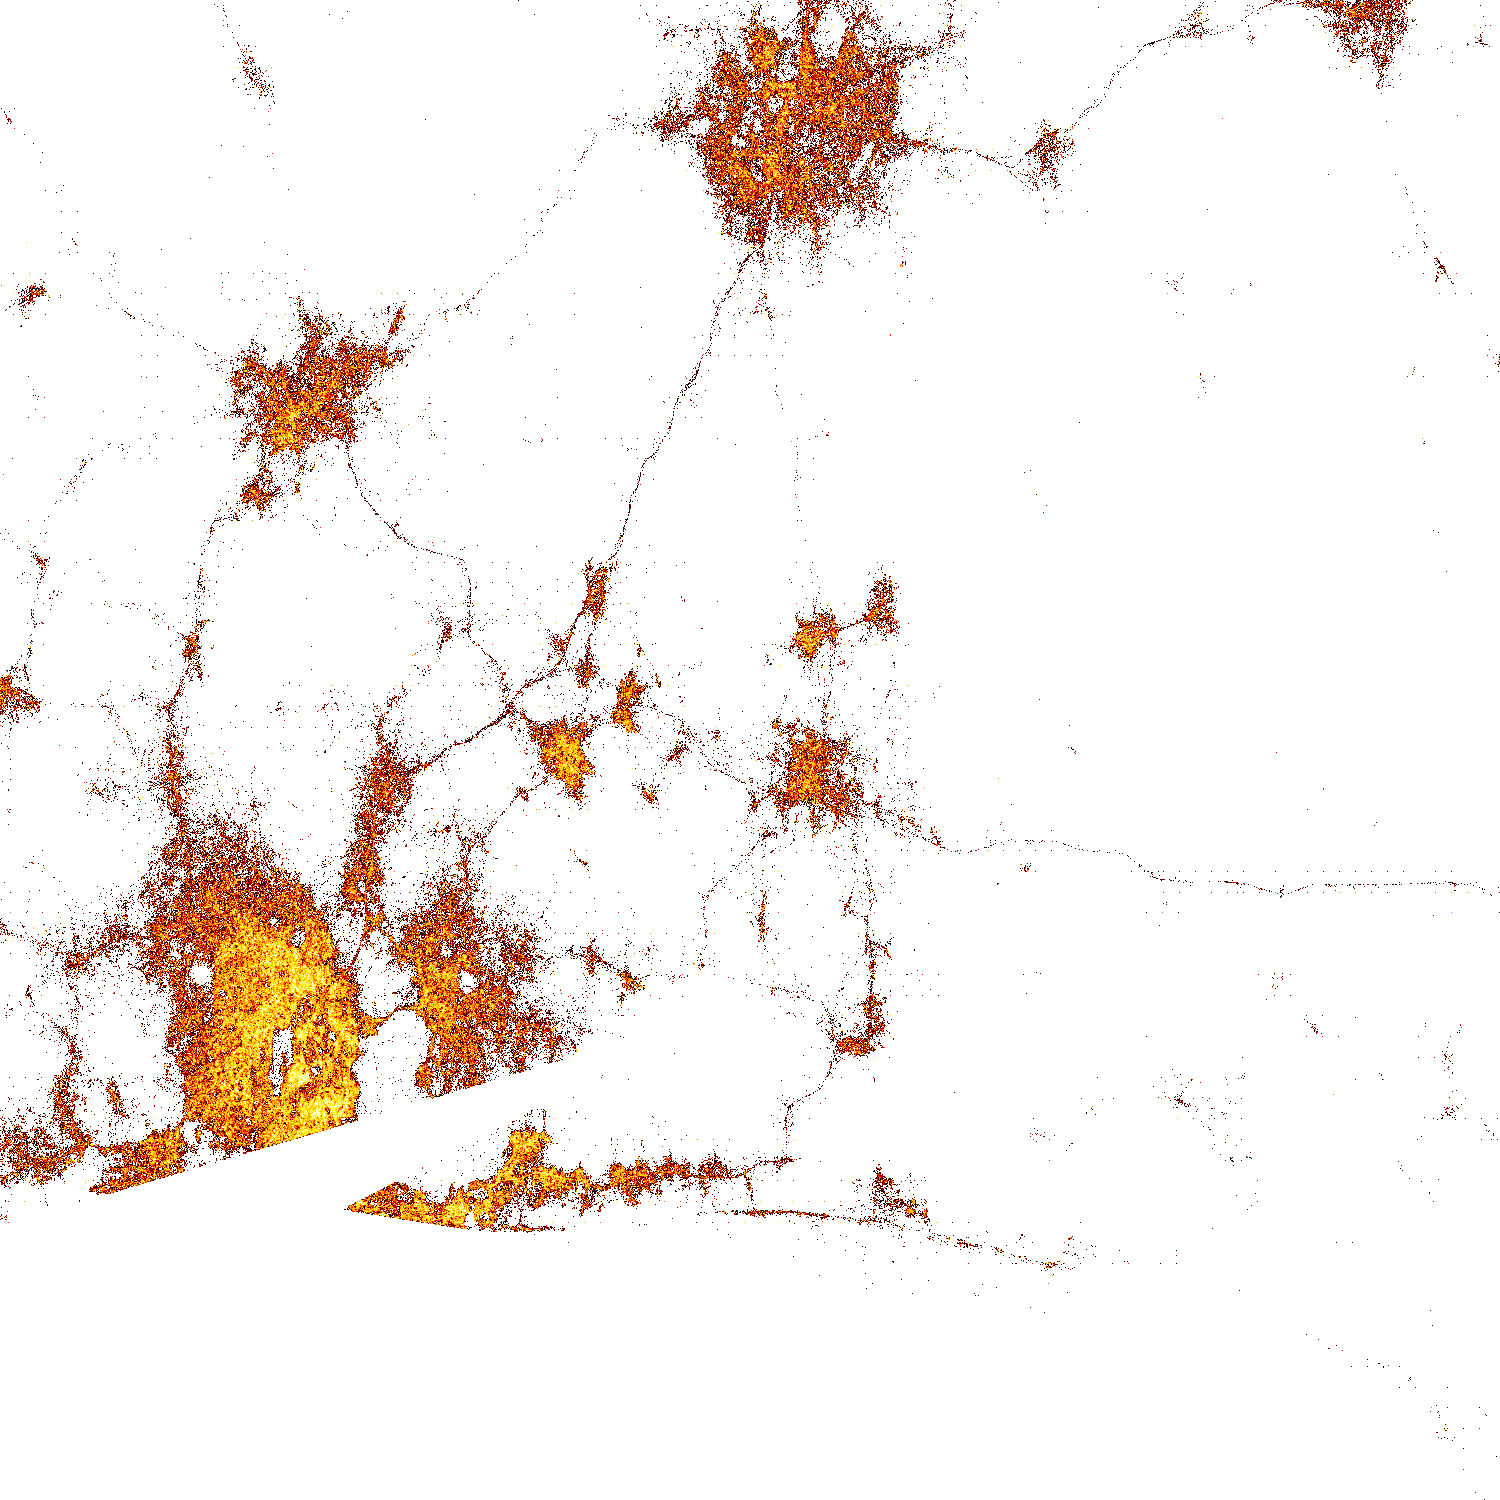

In [5]:
from colorcet import fire
import datashader.transfer_functions as tf
lagos = frame_nigeria.query("lon < 4.7").query("lon > 3").query("lat < 7.5").query("lat > 5.5")
#abuja = frame_nigeria.query("lon < 8").query("lon > 6.5").query("lat < 9.6").query("lat > 8.1")
# agg is an xarray object, see http://xarray.pydata.org/en/stable/ for more details
cvs = ds.Canvas(plot_width=1500, plot_height=1500)
agg_nig = cvs.points(lagos, x='lon', y='lat')
coords_lat, coords_lon = agg_nig.coords['lat'].values, agg_nig.coords['lon'].values

# Corners of the image, which need to be passed to mapbox
#coordinates = [[coords_lon[0], coords_lat[0]],
#               [coords_lon[-1], coords_lat[0]],
#               [coords_lon[-1], coords_lat[-1]],
#               [coords_lon[0], coords_lat[-1]]]


coordinates = [[coords_lon[0], coords_lat[-1]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[0], coords_lat[0]]               ]


img = tf.shade(agg_nig[::-1], cmap=fire).to_pil()


import plotly.express as px

# Trick to create rapidly a figure with mapbox axes
fig = px.scatter_mapbox(frame_nigeria[:1], lat='lat', lon='lon',zoom=8, height=1000, width=1000)

# Add the datashader image as a mapbox layer image
fig.update_layout(mapbox_style="carto-darkmatter",                  
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img,
                    "coordinates": coordinates
                }]
)
fig.show()



In [ ]:
from datashader.utils import lnglat_to_meters as webm
frame['easting'], frame['northing']  = [list(r) for r in webm(*(frame['lon'].values, frame['lat'].values))]

In [ ]:
print(frame_nigeria.lon.max())
print(frame_nigeria.lon.min())
print(frame_nigeria.lat.max())
print(frame_nigeria.lat.min())

In [ ]:
Nigeria     = (( 2.5,  15), (2.5, 15)) 

x_range,y_range = [list(r) for r in webm(*Nigeria)]

plot_width  = int(1200)
plot_height = int(plot_width)
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, 
                x_range=x_range, y_range=y_range)
agg = cvs.points(frame, 'easting', 'northing')

In [ ]:
volumes = tf.shade(agg, cmap=[ 'blue'], how='log')

img = tf.stack(volumes)#, accidents_data)

In [ ]:
img

In [ ]:
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import STAMEN_TERRAIN
output_notebook()

#Maryland      = (( -77.68,  -76.02), (38.50, 39.70))
#from datashader.utils import lnglat_to_meters as webm
#coords['easting'], coords['northing']  = [list(r) for r in webm(*(coords['long'].values, coords['lat'].values))]
#x_range,y_range = [list(r) for r in webm(*Maryland)]

#plot_width  = int(1200)
#plot_height = int(plot_width*7.0/12)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    p.add_tools(BoxZoomTool(match_aspect=True))

    return p


options = dict(line_color=None, fill_color='blue', size=1)
p = base_plot()
#p.add_tile(STAMEN_TERRAIN)

p.circle(x=frame[0:int(len(frame)/6)]['easting'], y=frame[0:int(len(frame)/6)]['northing'], **options) # other dataset: accident


show(p)

In [ ]:
background = "black"
print(frame.head())
print(x_range,y_range)
print(len(frame))

In [ ]:
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9
from IPython.core.display import HTML, display

export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.cm import hot
export(tf.shade(agg, cmap = hot, how='eq_hist'),"census_ds_mhot_eq_hist")

In [ ]:
export(tf.shade(agg, cmap = cm(Greys9,0.2), how='log'),"census_gray_log")

In [ ]:
grays2 = cm([(i,i,i) for i in np.linspace(0,255,99)])
grays2 += ["red"]
export(tf.shade(agg, cmap = grays2, how='eq_hist'),"census_gray_redhot1_eq_hist")

In [ ]:
img=(tf.shade(agg, cmap = hot, how='log'))[::-1].to_pil()

In [ ]:
img


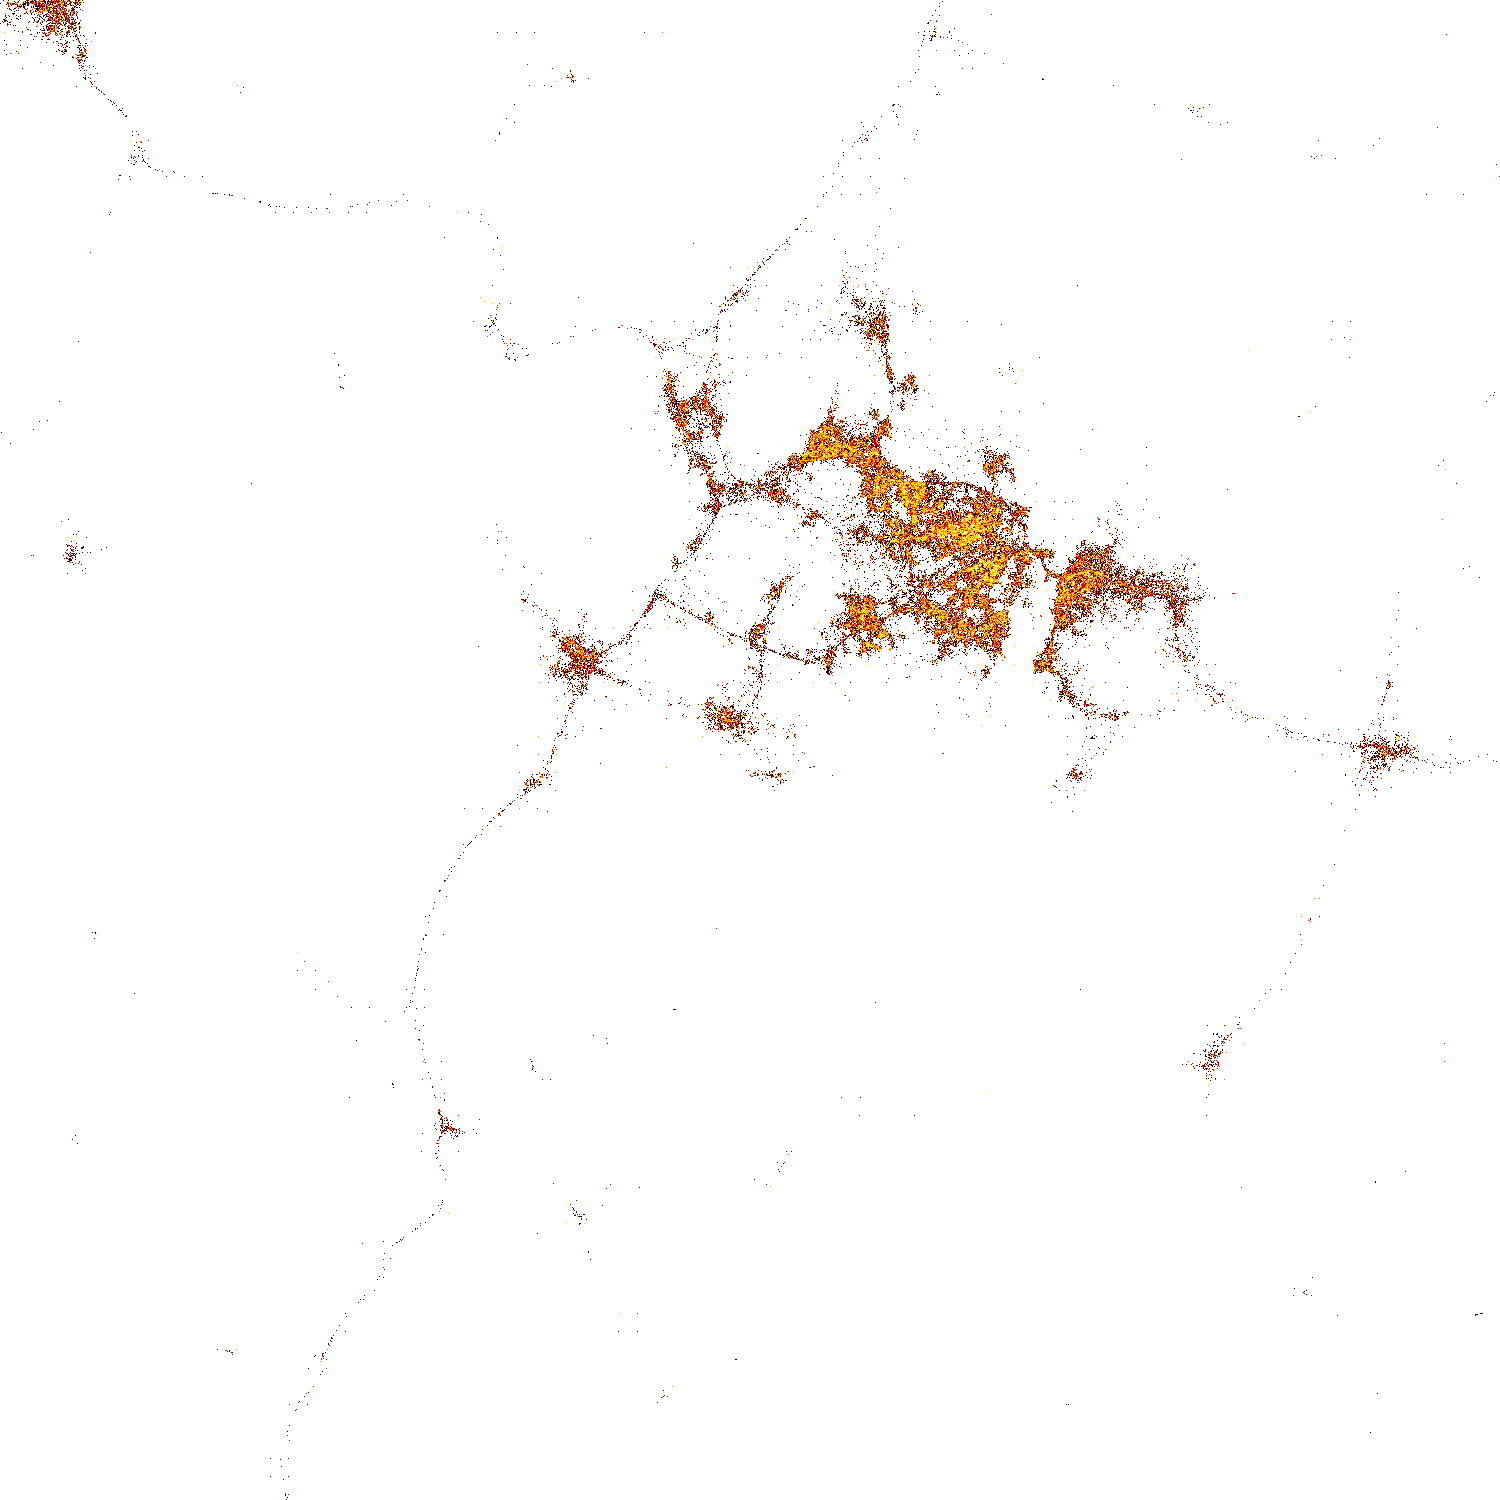

In [ ]:
agg_nig